In [1]:
!pip install yfinance seaborn statsmodels arch


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# --- world (from yfinance) ---
# keep only its Close, rename, and ensure its index is datetime
world = yf.download("CW8.PA", start="2015-01-02", end="2025-05-07", progress=False)
world = world[["Close"]].rename(columns={"Close":"world"})
world.index = pd.to_datetime(world.index)  # remove any tzinfo if present

# --- banks (same) ---
banks = yf.download("BNKE.PA", start="2015-01-02", end="2025-05-07", progress=False)
banks = banks[["Close"]].rename(columns={"Close":"banks"})
banks.index = pd.to_datetime(banks.index)

health = pd.read_csv("health.csv", decimal=',')
health = health[["Date", "Close"]].rename(columns={"Close":"health"}).set_index("Date")
health.index = pd.to_datetime(health.index)  # remove any tzinfo if present


YF.download() has changed argument auto_adjust default to True


In [4]:
banks = banks.xs('BNKE.PA', axis=1, level='Ticker')
world = world.xs('CW8.PA', axis=1, level='Ticker')

In [5]:
print(world.index.dtype, banks.index.dtype, health.index.dtype)


datetime64[ns] datetime64[ns] datetime64[ns]


In [6]:
health

,health
Date,
2015-01-02,74.86
2015-01-05,75.13
2015-01-06,74.32
2015-01-07,74.76
2015-01-08,77.25
...,...
2025-04-30,138.82
2025-05-02,140.69
2025-05-05,140.90


In [7]:
df = world.join([health, banks])

Ex 1:

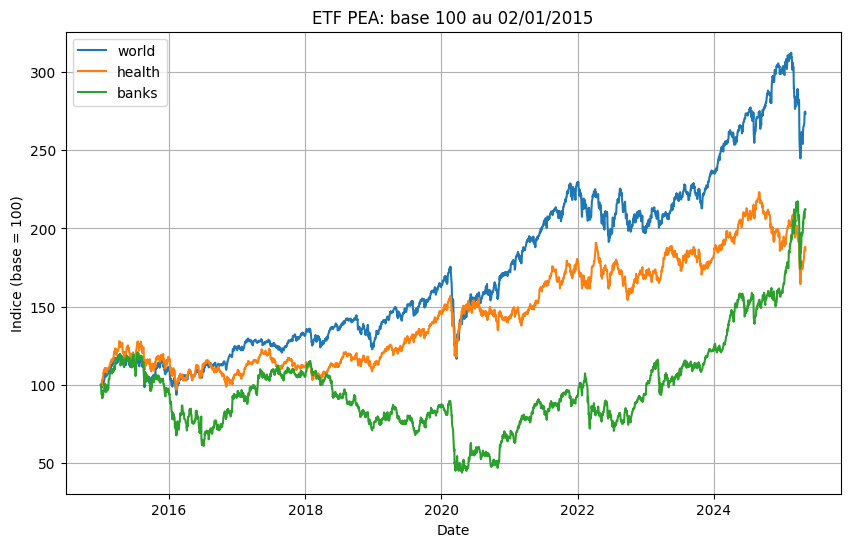

In [9]:
# compute the factor that makes each series start at 100
rebasing = 100 / df.iloc[0]

# apply it to get the normalized index
df_norm = df * rebasing

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)
plt.title("ETF PEA: base 100 au 02/01/2015")
plt.xlabel("Date")
plt.ylabel("Indice (base = 100)")
plt.legend()
plt.grid()
plt.show()


In [10]:
rets = df.pct_change().dropna()


C:\Users\Nagumesh\AppData\Local\Temp\ipykernel_68776\1427037023.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = df.pct_change().dropna()


In [11]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)               # or a big number
pd.set_option("display.expand_frame_repr", False)

Ex 2:

In [12]:
# 1) Statistiques de base
desc = rets.describe().T
# Cela vous donne : count, mean, std, min, 25%, 50%, 75%, max

# 2) Skewness et kurtosis
desc['skew']  = rets.skew()
desc['kurtosis'] = rets.kurtosis()

# 3) Rendement annualisé (%) et volatilité annualisée (%)
# On prend 252 séances de bourse par an
desc['annualized_mean_%'] = desc['mean'] * 252 * 100
desc['annualized_vol_%']  = desc['std']  * np.sqrt(252) * 100

print(desc)

         count      mean       std       min       25%       50%       75%       max      skew  kurtosis  annualized_mean_%  annualized_vol_%
world   2646.0  0.000429  0.009820 -0.082651 -0.003867  0.000898  0.005330  0.082218 -0.681169  7.449215          10.801000         15.588963
health  2646.0  0.000288  0.010303 -0.091095 -0.005412  0.000563  0.006044  0.052354 -0.460862  4.857736           7.250872         16.354781
banks   2646.0  0.000455  0.018383 -0.180241 -0.008433  0.000696  0.009933  0.138168 -0.656784  9.673175          11.462222         29.181605


In [13]:
corr_matrix = rets.corr()
print(corr_matrix)

           world    health     banks
world   1.000000  0.675971  0.597472
health  0.675971  1.000000  0.393548
banks   0.597472  0.393548  1.000000


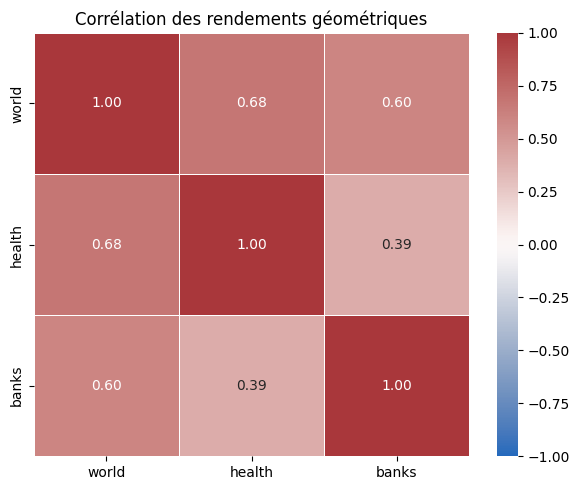

In [14]:
plt.figure(figsize=(6,5))
sns.heatmap(
    corr_matrix,
    annot=True,        # affiche les valeurs
    fmt=".2f",         # format à 2 décimales
    cmap="vlag",       # palette divergente sympa
    vmin=-1, vmax=1,   # bornes de la colorbar
    linewidths=0.5     # séparations entre les cellules
)
plt.title("Corrélation des rendements géométriques")
plt.tight_layout()
plt.show()

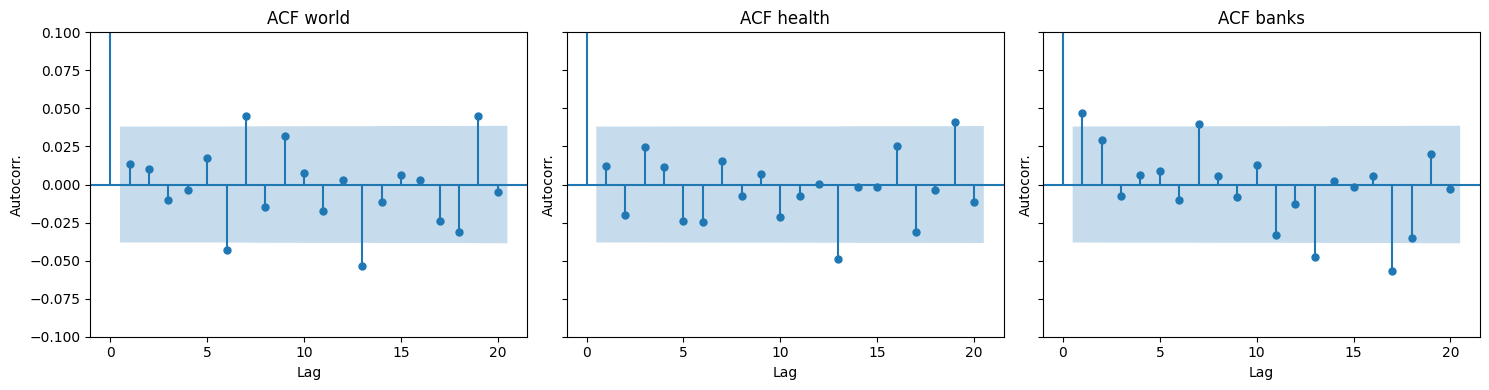

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)

# 2. Tracer chaque ACF dans son propre axe
for ax, col in zip(axes, rets.columns):
    plot_acf(rets[col], lags=20, ax=ax)
    ax.set_title(f"ACF {col}")
    ax.set_xlabel("Lag")
    ax.set_ylim(-0.1, 0.1)
    ax.set_ylabel("Autocorr.")

plt.tight_layout()
plt.show()


In [16]:
from arch import arch_model

# Fusionner les DataFrames
data = pd.concat([world, banks, health], axis=1).dropna()
print(data.head())  # Vérification

# Calcul des rendements géométriques (log-rendements)
rets = np.log(data / data.shift(1)).dropna()  # data = DataFrame avec world, banks, health

                 world       banks  health
Date                                      
2015-01-02  190.495499  106.094299   74.86
2015-01-05  188.271500  101.160004   75.13
2015-01-06  186.659302   99.543602   74.32
2015-01-07  189.432404   99.116699   74.76
2015-01-08  193.273697  102.009804   77.25


Ex 3:

Colonnes disponibles dans rets: ['world', 'banks', 'health']

Analyse de World (colonne: world)

=== Résultats GARCH(1,1) pour World ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  world   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3309.27
Distribution:                  Normal   AIC:                           6626.53
Method:            Maximum Likelihood   BIC:                           6650.04
                                        No. Observations:                 2636
Date:                Thu, May 15 2025   Df Residuals:                     2635
Time:                        23:01:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--

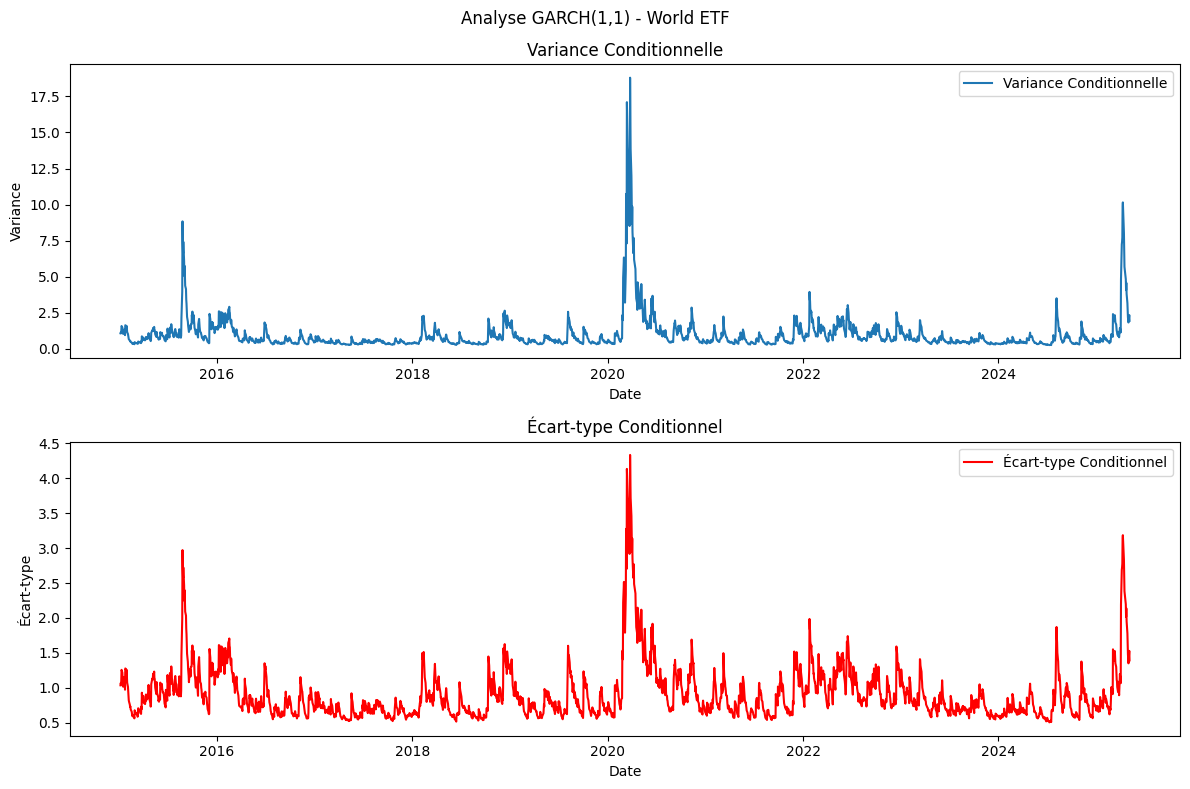


Analyse de Banks (colonne: banks)

=== Résultats GARCH(1,1) pour Banks ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  banks   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4987.21
Distribution:                  Normal   AIC:                           9982.42
Method:            Maximum Likelihood   BIC:                           10005.9
                                        No. Observations:                 2636
Date:                Thu, May 15 2025   Df Residuals:                     2635
Time:                        23:01:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------

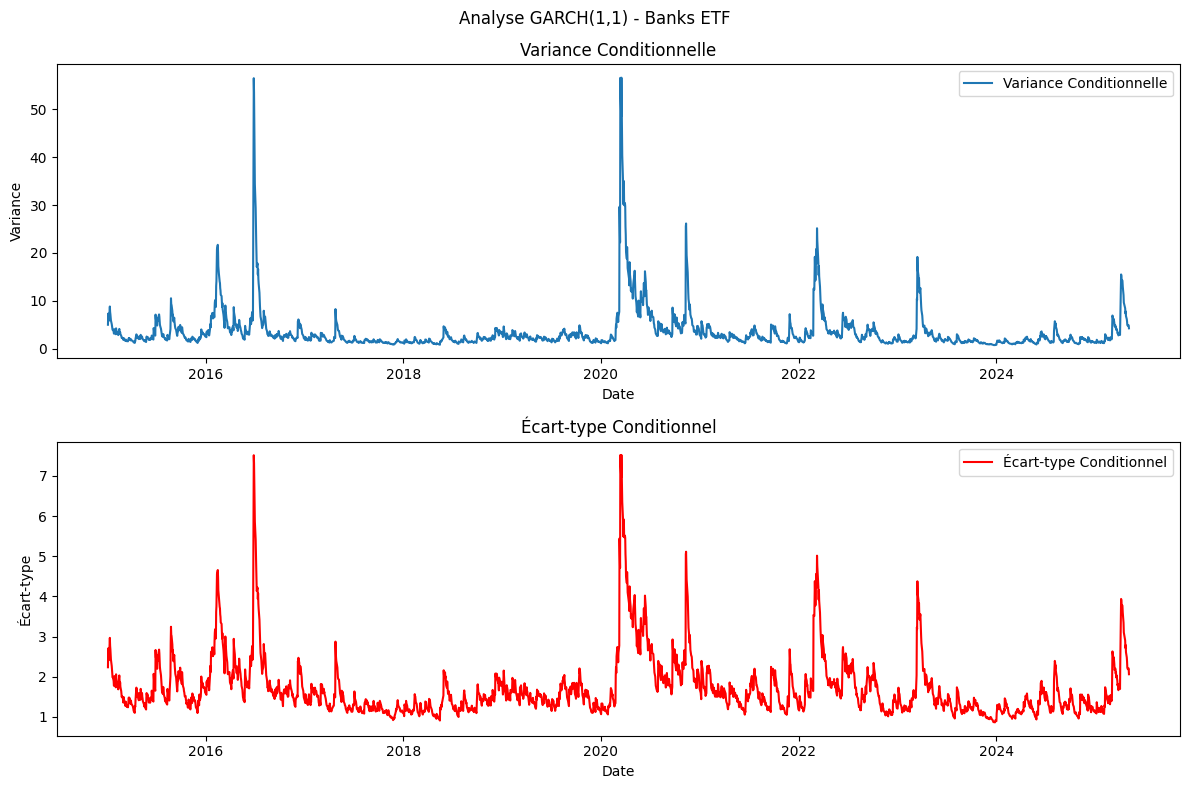


Analyse de Health (colonne: health)

=== Résultats GARCH(1,1) pour Health ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 health   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3604.73
Distribution:                  Normal   AIC:                           7217.46
Method:            Maximum Likelihood   BIC:                           7240.97
                                        No. Observations:                 2636
Date:                Thu, May 15 2025   Df Residuals:                     2635
Time:                        23:01:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------

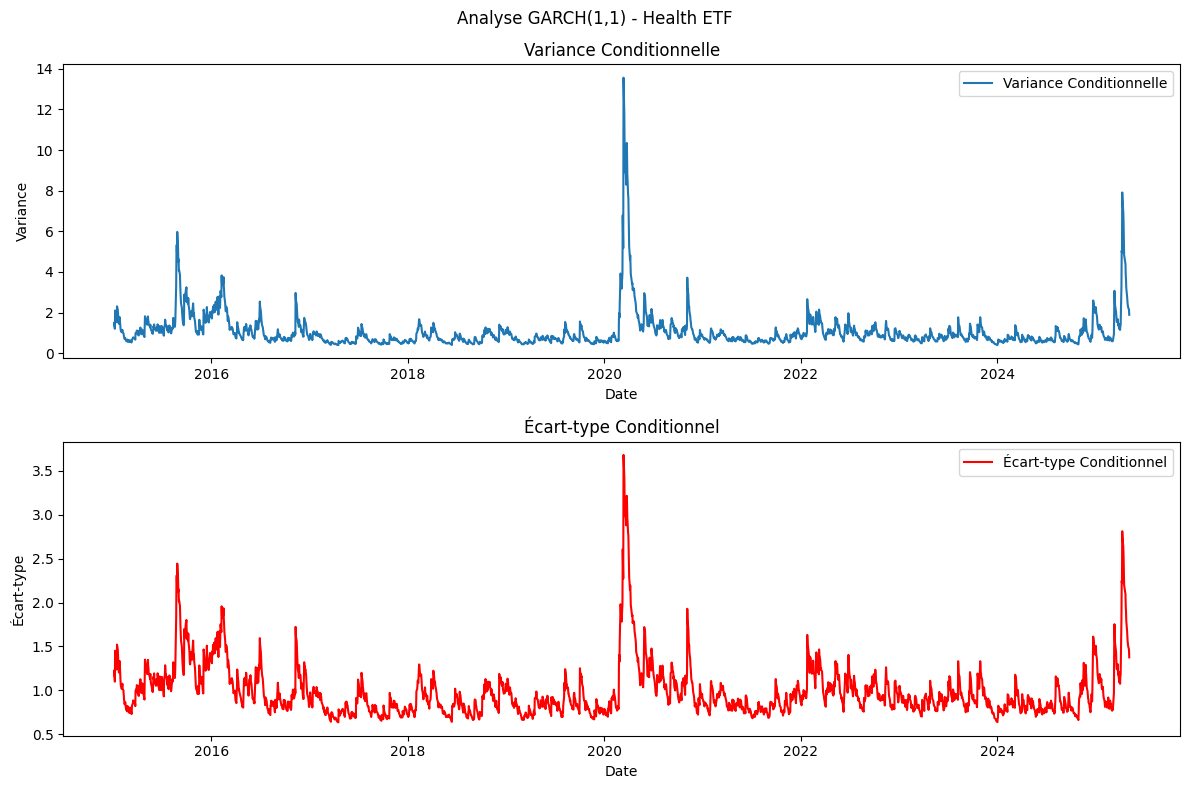


=== Synthèse des résultats ===

World ETF:
{'omega': np.float64(0.040635175486168885), 'alpha': np.float64(0.1470816141148878), 'beta': np.float64(0.8117536734329559), 'persistence': np.float64(0.9588352875478436)}

Banks ETF:
{'omega': np.float64(0.09160639925073397), 'alpha': np.float64(0.1268595215097224), 'beta': np.float64(0.8509254671044383), 'persistence': np.float64(0.9777849886141607)}

Health ETF:
{'omega': np.float64(0.04268378177750897), 'alpha': np.float64(0.0983344828534814), 'beta': np.float64(0.8604316846008279), 'persistence': np.float64(0.9587661674543093)}


In [20]:
import matplotlib.pyplot as plt
from arch import arch_model

def estimate_and_plot_garch(returns, name):
    """
    Estime un modèle GARCH(1,1) et trace la variance conditionnelle
    
    Paramètres:
    returns (pd.Series): Série temporelle des rendements
    name (str): Nom de l'actif pour le titre des graphiques
    
    Retourne:
    dict: Paramètres du modèle GARCH
    """
    # Vérification des entrées
    if returns is None or len(returns) == 0:
        raise ValueError(f"Les rendements pour {name} sont vides ou None")
    
    try:
        # Multiplier par 100 pour la stabilité numérique
        model = arch_model(returns * 100, mean='Constant', vol='GARCH', p=1, q=1)
        results = model.fit(update_freq=5, disp='off')
    except Exception as e:
        print(f"Erreur lors de l'estimation GARCH pour {name}: {str(e)}")
        return None
    
    print(f"\n=== Résultats GARCH(1,1) pour {name} ===")
    print(results.summary())
    
    # Extraire la variance conditionnelle
    conditional_variance = results.conditional_volatility ** 2
    conditional_std = results.conditional_volatility
    
    # Créer des sous-graphiques
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(f'Analyse GARCH(1,1) - {name} ETF')
    
    # Tracer la variance conditionnelle
    ax1.plot(returns.index, conditional_variance, label='Variance Conditionnelle')
    ax1.set_title('Variance Conditionnelle')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Variance')
    ax1.legend()
    
    # Tracer l'écart-type conditionnel
    ax2.plot(returns.index, conditional_std, label='Écart-type Conditionnel', color='red')
    ax2.set_title('Écart-type Conditionnel')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Écart-type')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'omega': results.params['omega'],
        'alpha': results.params['alpha[1]'],
        'beta': results.params['beta[1]'],
        'persistence': results.params['alpha[1]'] + results.params['beta[1]']
    }

# Vérification des colonnes disponibles
print("Colonnes disponibles dans rets:", rets.columns.tolist())

# Dictionnaire pour mapper les noms des ETFs aux noms de colonnes possibles
etfs = {
    'World': ['CW8.PA', 'World', 'world', 'CW8', 'MSCI World'], 
    'Banks': ['BNKE.PA', 'Banks', 'banks', 'BNKE', 'EU Banks'],
    'Health': ['health', 'Health', 'HEALTH.PA', 'SXDP']
}

# Estimation pour chaque ETF
params = {}
for etf_name, possible_columns in etfs.items():
    found = False
    for col in possible_columns:
        if col in rets.columns:
            print(f"\nAnalyse de {etf_name} (colonne: {col})")
            params[etf_name] = estimate_and_plot_garch(rets[col], etf_name)
            found = True
            break
    if not found:
        print(f"\nAucune colonne correspondante trouvée pour {etf_name}")
        print(f"Colonnes essayées: {possible_columns}")

# Affichage des résultats
print("\n=== Synthèse des résultats ===")
for etf_name, result in params.items():
    if result is not None:
        print(f"\n{etf_name} ETF:")
        print(result)
    else:
        print(f"\n{etf_name} ETF: Aucun résultat (colonne non trouvée ou erreur d'estimation)")

Ex: 5

Noms des colonnes dans votre DataFrame:
Index(['world', 'banks', 'health'], dtype='object')
Dictionnaire de noms d'affichage:
{'world': 'world', 'banks': 'Banks ETF', 'health': 'Health ETF'}
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, May, 2025
Time:                     23:27:26
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.3207
Nobs:                     2631.00    HQIC:                  -27.3890
Log likelihood:           24929.7    FPE:                1.22528e-12
AIC:                     -27.4279    Det(Omega_mle):     1.20320e-12
--------------------------------------------------------------------
Results for equation world
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000382         0.00

c:\Users\Nagumesh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


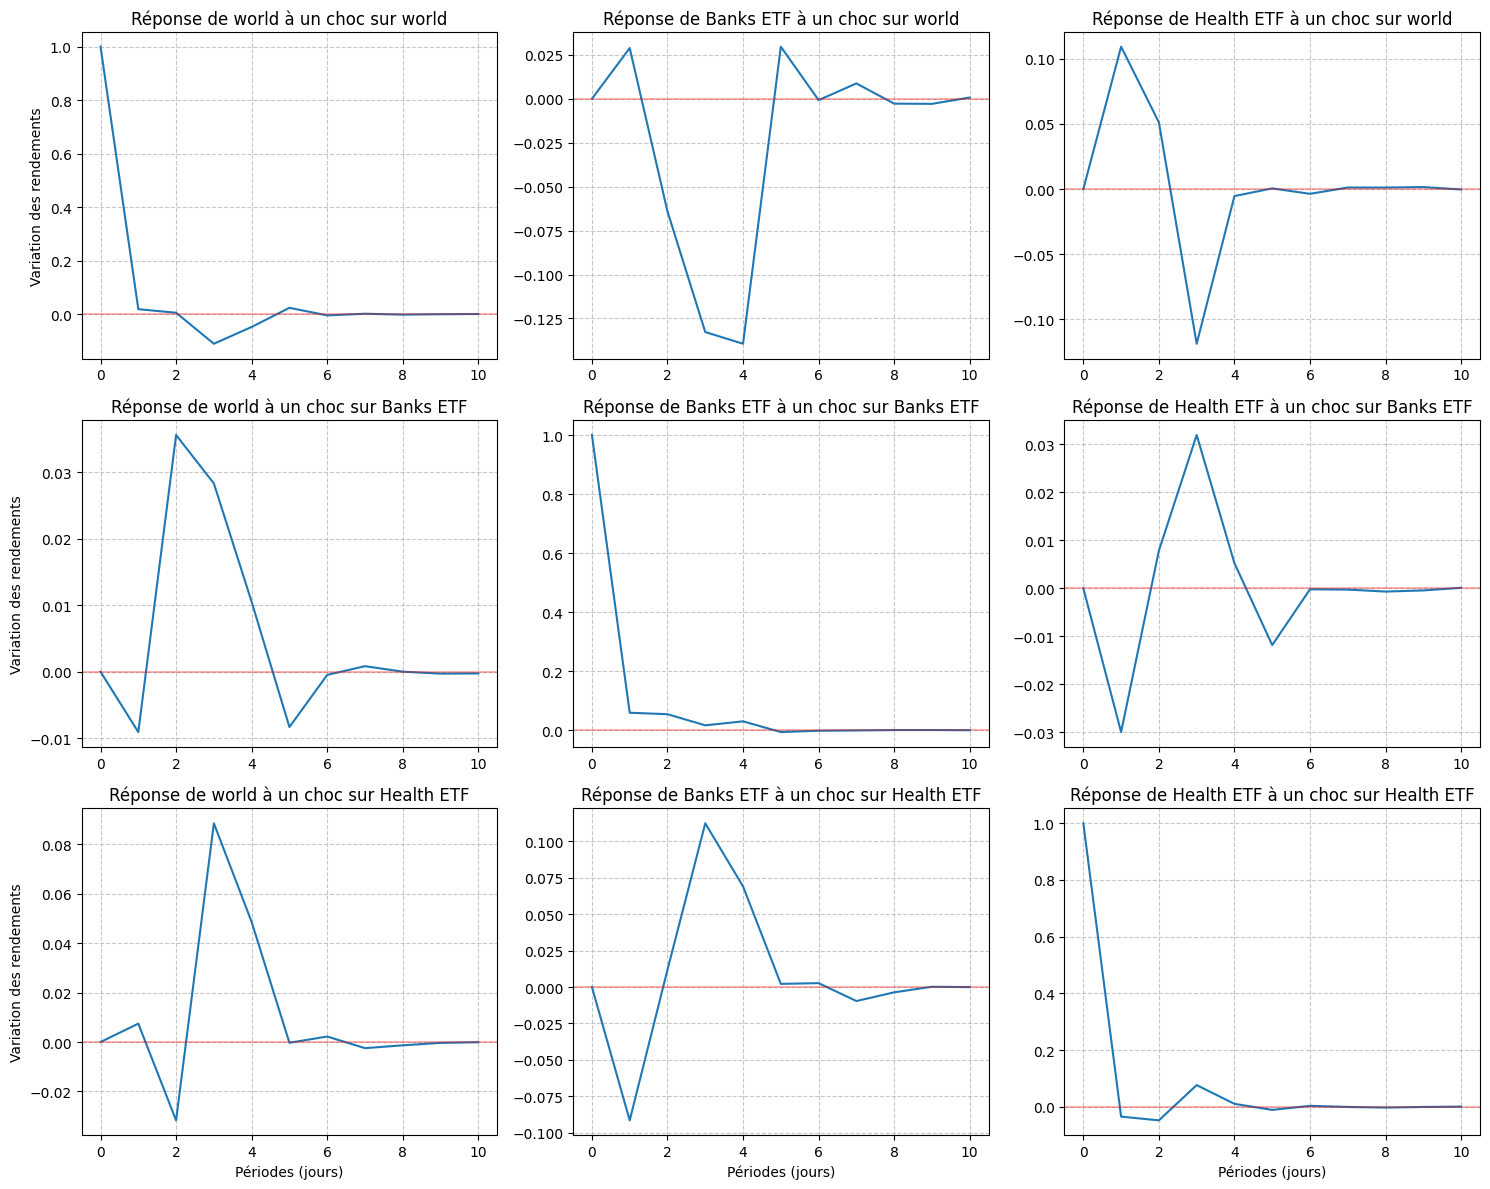

In [21]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# On suppose que vous avez déjà vos rendements dans le DataFrame 'rets'
# Mais maintenant on s'adapte à vos noms de colonnes actuels

# 1. Vérifier les noms de colonnes
print("Noms des colonnes dans votre DataFrame:")
print(rets.columns)

# 2. Créer un dictionnaire de noms pour l'affichage, basé sur vos colonnes réelles
etf_names = {}
for col in rets.columns:
    if 'CW8' in col:
        etf_names[col] = 'World ETF'
    elif 'BNK' in col or 'bank' in col.lower():
        etf_names[col] = 'Banks ETF'
    elif 'health' in col.lower():
        etf_names[col] = 'Health ETF'
    else:
        etf_names[col] = col  # Utiliser le nom original si aucun match

print("Dictionnaire de noms d'affichage:")
print(etf_names)

# 3. Fixer explicitement un nombre de lags raisonnable
lag_order = 5

# 4. Estimer le modèle VAR avec ce lag fixe
model = VAR(rets)
var_model = model.fit(lag_order)
print(var_model.summary())

# 5. Vérifier que le modèle a bien convergé
print(f"Le modèle a-t-il convergé? {'Oui' if var_model.k_ar > 0 else 'Non'}")
print(f"Nombre de lags utilisés: {var_model.k_ar}")

# 6. Analyser les fonctions de réponse aux impulsions
ma_rep = var_model.ma_rep(10)  # Représentation moyenne mobile sur 10 périodes

# 7. Visualiser les IRF manuellement
plt.figure(figsize=(15, 12))
response_names = list(rets.columns)

# Pour chaque paire d'ETFs
for i, impulse in enumerate(response_names):
    for j, response in enumerate(response_names):
        plt.subplot(3, 3, i*3 + j + 1)
        
        # Extraire la réponse impulsionnelle spécifique
        irf_values = [ma_rep[t][j, i] for t in range(len(ma_rep))]
        
        # Tracer la réponse
        plt.plot(range(len(irf_values)), irf_values)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        
        # Utiliser les étiquettes du dictionnaire etf_names
        plt.title(f'Réponse de {etf_names[response]} à un choc sur {etf_names[impulse]}')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if j == 0:  # Première colonne
            plt.ylabel('Variation des rendements')
        if i == 2:  # Dernière ligne
            plt.xlabel('Périodes (jours)')

plt.tight_layout()
plt.savefig('var_impulse_responses.png', dpi=300)
plt.show()

